In [177]:
from event import *
from mm1 import *
from scheduler import *
from simulator import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [178]:
# SETTINGS
SEED = 42
WARMUP = False
warmup_events = 500
lambda_ = 1 #arrival_rate
mu = 1.5 #service_rate

os.makedirs("results", exist_ok=True) if not os.path.exists("results") else None
csv_name = f"mm1_{lambda_}_{mu}_warmup.csv" if WARMUP else f"mm1_{lambda_}_{mu}_nowarmup.csv"
path_to_csv=os.getcwd() + f"/results/{csv_name}.csv"

#delete the file if it exists
if os.path.exists(path_to_csv):
    os.remove(path_to_csv)

# Setup and run the simulator

In [179]:

# Termination policy: stop when the simulation time reaches 100,000 time units
policy = (TerminationPolicy()
          .add(lambda srv, sched, narr, ndep, abs_t: abs_t >= int(1e3)).all())

# Run the simulation
print(f"Running simulation with arrival rate: {lambda_}, service rate: {mu}")
sim = Simulator(arrival_rate=lambda_, service_rate=mu, seed=SEED, path_to_csv=path_to_csv)
sim.run(termination_condition=policy)
sim.report()

Running simulation with arrival rate: 1, service rate: 1.5
Running simulation...
Arrivals: 928
Departures: 926
Final queue length: 1
Server busy: True
Total Arrivals: 928.000
Total Services: 926.000


# Plots of Utilization and packets in the system

In [180]:
# Load the simulation results from the CSV file
data = pd.read_csv(path_to_csv)

if WARMUP:
    #remove first warmup_events
    data = data.iloc[warmup_events:]
    
# compute total packets in the system (queue + 1 if busy, else queue)
data['total_current_packets'] = data['queue_length'] + data['server_busy'].astype(int)

ro = lambda_ / mu
# Theoretical average number of packets in the system (stationary regime)
t_packet_mean = ro / (1 - ro) if ro < 1 else np.inf # if arrival rate >= service rate, the system is unstable (it saturates)

print(f"Average number of packets in the system: {data['total_current_packets'].mean():.4f} (theoretical: {t_packet_mean:.4f})")
#compute the average utilization
data['delta_t'] = data['time'].shift(-1) - data['time']
data['delta_t'] = data['delta_t'].fillna(0.0) # put to zero last value


data['cumulative_busy_time'] = (data['server_busy'] * data['delta_t']).cumsum()
data['elapsed_time'] = data['time'] - data['time'].iloc[0]

data['cumulative_utilization'] = data['cumulative_busy_time'] / data['elapsed_time']
data['cumulative_utilization'] = data['cumulative_utilization'].fillna(0.0) ##fill the Nan in first row

emp_util_mean =data['cumulative_utilization'].iloc[-1]

print(f"Utilization: {emp_util_mean:.4f} (theoretical: {lambda_ / mu:.4f})")

Average number of packets in the system: 1.9941 (theoretical: 2.0000)
Utilization: 0.5983 (theoretical: 0.6667)


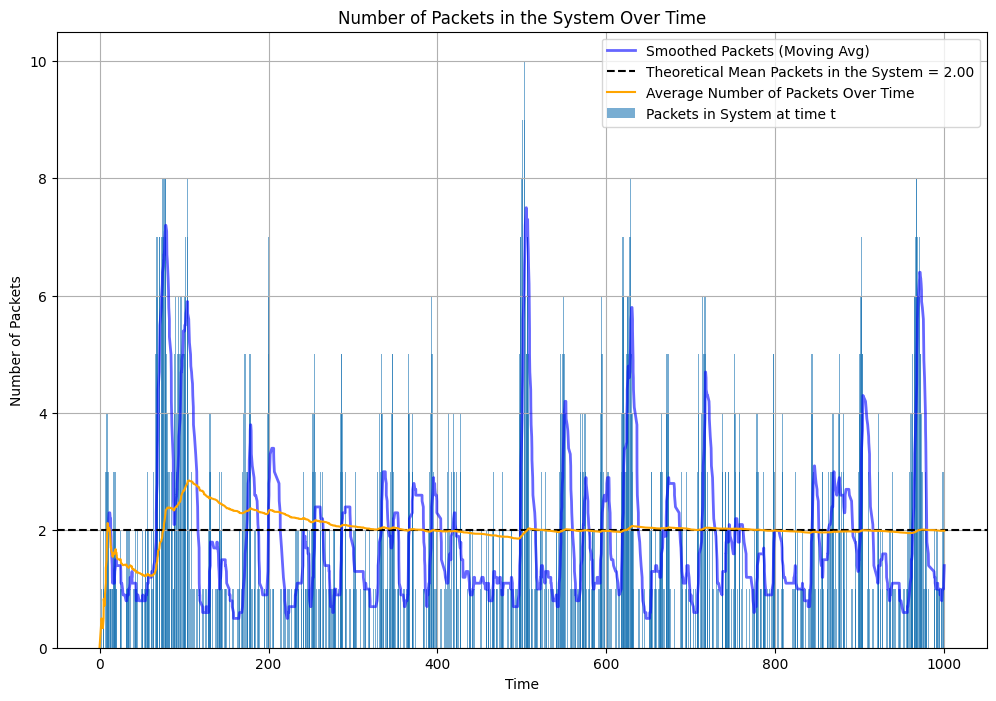

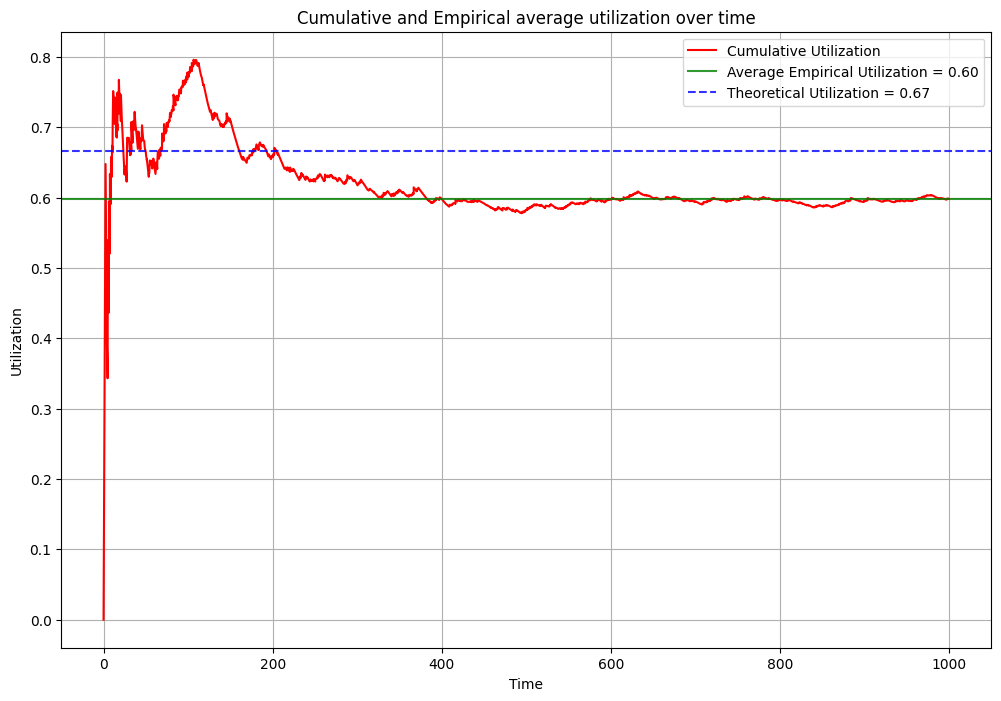

In [181]:
# Plot the number of packets in the system over time
plt.figure(figsize=(12, 8))
data['smoothed_packets'] = data['total_current_packets'].rolling(window=20).mean()
plt.plot(data['time'], data['smoothed_packets'], color='blue', label='Smoothed Packets (Moving Avg)', linewidth=2, alpha=0.6)
plt.bar(data['time'], data['total_current_packets'], label='Packets in System at time t', alpha=0.6)
plt.axhline(y=t_packet_mean, color='black', linestyle='--', label=f'Theoretical Mean Packets in the System = {t_packet_mean:.2f}')
plt.plot(data['time'], data['total_current_packets'].expanding().mean(), color='orange', label='Average Number of Packets Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Packets')
plt.title('Number of Packets in the System Over Time')
plt.legend()
plt.grid()

plt.figure(figsize=(12, 8))
plt.plot(data['time'], data['cumulative_utilization'], label='Cumulative Utilization', color='red')
plt.axhline(emp_util_mean, color='green', label=f'Average Empirical Utilization = {emp_util_mean:.2f}', alpha=0.8)
plt.axhline(ro, color='blue', linestyle='--', label=f'Theoretical Utilization = {ro:.2f}', alpha=0.8)
plt.xlabel('Time')
plt.ylabel('Utilization')
plt.title('Cumulative and Empirical average utilization over time') 
plt.legend()
plt.grid()
plt.show()

# Running simulation batches to assess the behavior of the system with different parameters